In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2023-06-08 15:25:58.423885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-08 15:26:00.240050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:00.243908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:00.244113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 2,
"pred_session_name" : 'rand_walk_interpol_2_uav',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

2023-06-08 15:26:03.945237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:03.945486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:03.945654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)
INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-08 15:26:07.547259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:07.547452: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:26:07.547573: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:26:07.547859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:07.548038: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-08 15:26:08.124554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:08.124771: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:26:08.124863: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:26:08.125093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:08.125271: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-08 15:26:10.704171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:10.704361: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:26:10.704441: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:26:10.704668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:10.704852: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-08 15:26:11.003911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:11.004133: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:26:11.004223: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:26:11.004447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:26:11.004619: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 4), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-08--15:26:11'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:
# Use for time profiling
# def main():
#     env.ee.policy = "random"
#     env.ee.action_space.repeat_probability = 0.9
#     all_rewards = []
#     final_errors = []
    
#     for _ in range(1):
#         time_step = train_py_env.reset()
#         reward_in_episode = 0
#         while not time_step.is_last():
#             time_step = train_py_env.step(action=1)
#             reward_in_episode += time_step.reward
#         all_rewards.append(reward_in_episode)
#         final_errors.append(env.current_error)
#     print("Reward per epsisode", np.mean(all_rewards))
#     print("Average error", np.mean(final_errors))
#     env.ee.policy = "rl"

# %lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-08 15:26:12.667854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-08 15:26:13.266980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
# Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # # Create a timestep with TF values
        # step_type = tf.constant(time_steps[agent_idx].step_type)
        # reward = tf.constant(time_steps[agent_idx].reward)
        # discount = tf.constant(time_steps[agent_idx].discount)
        # observation = tf.constant(time_steps[agent_idx].observation)
        # tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(time_steps[agent_idx])
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors



In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(random_policy, use_tf_function=True), n_agents, num_episodes=50)

print((rand_reward, rand_pred_error, np.median(errors)))


2023-06-08 15:26:13.859304: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-08 15:26:13.859410: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-08 15:26:19.108882: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


(20.80906895637512, 19.35579781381796, 18.194164809663988)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpxo0fmnqx.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpxo0fmnqx
[reverb/cc/platform/default/server.cc:71] Started replay server on port 35947


In [17]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[ 0.61020887,  0.16337873,  0.        ,  0.        ],
          [ 0.5862261 ,  0.19082241,  0.        ,  0.        ],
          [ 0.5791635 ,  0.17424402,  0.        ,  0.        ],
          ...,
          [ 0.8374706 ,  0.11865906,  0.        ,  0.        ],
          [ 0.78219014,  0.13904561,  0.        ,  0.        ],
          [ 0.38508454,  0.15496804,  0.        ,  0.        ]],
  
         [[ 0.        ,  0.13700321,  0.        ,  0.        ],
          [ 0.        ,  0.1658064 ,  0.        ,  0.        ],
          [ 0.        ,  0.14771864,  0.        ,  0.        ],
          ...,
          [ 0.83375466,  0.09932449,  0.        ,  0.        ],
          [ 0.8308821 ,  0.1023934 ,  0.        ,  0.        ],
          [ 0.84164697,  0.1053193 ,  0.        ,  0.        ]],
  
         [[ 0.        ,  0.14419247,  0.        ,  0.        ],
          [ 0.        ,  0.13168673,  0.        ,  0.        

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
# This will be a list for multiple agents
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents = n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [22]:
best_reward = np.inf
losses = []
collect_rewards = []

In [23]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [24]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {2}'.format(step, avg_return, avg_error, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > np.median(errors):
      print("Saving model")
      best_reward = np.median(errors)
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error, errors = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, num_eval_episodes)
      avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True), n_agents, num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {2}'.format(step, avg_return, avg_error, np.median(errors)))
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {2}'.format(step, avg_return_collect, avg_error_collect, np.median(errors_collect)))

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3909640) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3909640) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3909640) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3909640) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3909640) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3909640) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2023-06-08 15:41:22.550890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum' with dtype int32
	 [[{{node critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum}}]]
2023-06-08 15:41:22.559899: I tensorflow/core/common_runtime/executor.cc:1197] [/d

step = 0: loss = 4.248987674713135,  rew = 0.0


step = 0: Average Return = 22.378072344064712, Average Error = 17.671998960628084, Median Error = 17.671998960628084
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


step = 0: Average Return = 22.67314753552278, Average Error = 17.360609908853753, Median Error = 17.360609908853753
step = 0: Average Return = 22.31408950984478, Average Error = 17.85175842183165, Median Error = 17.85175842183165
step = 1000: loss = 4.196565628051758,  rew = 20.755404233932495
step = 2000: loss = 4.139157772064209,  rew = 23.316407203674316
step = 3000: loss = 4.0948076248168945,  rew = 22.73755371570587
step = 4000: loss = 4.040224075317383,  rew = 22.39166796207428
step = 5000: loss = 3.9837777614593506,  rew = 21.922674775123596
step = 6000: loss = 3.9374771118164062,  rew = 23.611317574977875
step = 7000: loss = 3.9039602279663086,  rew = 21.83401733636856
step = 8000: loss = 3.862245798110962,  rew = 21.83798849582672
step = 9000: loss = 3.8922483921051025,  rew = 25.18528401851654
step = 10000: loss = 3.8434157371520996,  rew = 26.82625651359558
step = 11000: loss = 3.7492172718048096,  rew = 20.27759999036789
step = 12000: loss = 3.747443675994873,  rew = 21.624

step = 50000: Average Return = 22.03293624639511, Average Error = 17.99100718144325, Median Error = 17.99100718144325
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


step = 50000: Average Return = 21.8118515564998, Average Error = 18.226376957865376, Median Error = 18.226376957865376
step = 50000: Average Return = 22.51478468179703, Average Error = 17.853334800050835, Median Error = 17.853334800050835
step = 51000: loss = 3.5743346214294434,  rew = 23.140831291675568
step = 52000: loss = 3.5504655838012695,  rew = 23.877383768558502
step = 53000: loss = 3.5192999839782715,  rew = 23.144501447677612
step = 54000: loss = 3.6307764053344727,  rew = 22.802579402923584
step = 55000: loss = 3.5308051109313965,  rew = 23.82604479789734
step = 56000: loss = 3.608584403991699,  rew = 23.215481638908386
step = 57000: loss = 3.588949680328369,  rew = 24.179041385650635
step = 58000: loss = 3.6019539833068848,  rew = 22.507061064243317
step = 59000: loss = 3.573432445526123,  rew = 23.848867416381836
step = 60000: loss = 3.540188789367676,  rew = 24.9757319688797
step = 61000: loss = 3.5683488845825195,  rew = 20.57667374610901
step = 62000: loss = 3.529849767

step = 100000: Average Return = 22.309307058056195, Average Error = 17.756649278433148, Median Error = 17.756649278433148
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


step = 100000: Average Return = 21.656560777127744, Average Error = 18.787742021129475, Median Error = 18.787742021129475
step = 100000: Average Return = 22.19447132587433, Average Error = 18.01827614197029, Median Error = 18.01827614197029
step = 101000: loss = 3.4650697708129883,  rew = 22.29049801826477
step = 102000: loss = 3.4846572875976562,  rew = 23.273147642612457
step = 103000: loss = 3.471020221710205,  rew = 22.108395397663116
step = 104000: loss = 3.4692492485046387,  rew = 22.356869280338287
step = 105000: loss = 3.5054471492767334,  rew = 24.46984499692917
step = 106000: loss = 3.491394519805908,  rew = 19.553174078464508
step = 107000: loss = 3.4661645889282227,  rew = 22.70432412624359
step = 108000: loss = 3.4610888957977295,  rew = 23.28983098268509
step = 109000: loss = 3.509164333343506,  rew = 24.4815856218338
step = 110000: loss = 3.4547476768493652,  rew = 23.96790087223053
step = 111000: loss = 3.468575954437256,  rew = 21.503405272960663
step = 112000: loss = 

step = 150000: Average Return = 22.37738003394256, Average Error = 17.692825458645803, Median Error = 17.692825458645803
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


step = 150000: Average Return = 22.373252199490864, Average Error = 17.64000211133826, Median Error = 17.64000211133826
step = 150000: Average Return = 22.177399490475654, Average Error = 18.111909306874228, Median Error = 18.111909306874228
step = 151000: loss = 3.3962807655334473,  rew = 21.076279878616333
step = 152000: loss = 3.3827733993530273,  rew = 24.381305277347565
step = 153000: loss = 3.461249589920044,  rew = 23.517310619354248
step = 154000: loss = 3.393177032470703,  rew = 24.384333193302155
step = 155000: loss = 3.421882152557373,  rew = 25.533142685890198
step = 156000: loss = 3.4105217456817627,  rew = 23.052485287189484
step = 157000: loss = 3.381563186645508,  rew = 26.348870992660522
step = 158000: loss = 3.4356467723846436,  rew = 23.320378363132477
step = 159000: loss = 3.44899582862854,  rew = 23.145049810409546
step = 160000: loss = 3.420604705810547,  rew = 26.554295420646667
step = 161000: loss = 3.4639720916748047,  rew = 20.968693494796753
step = 162000: lo

step = 200000: Average Return = 22.813818713029224, Average Error = 17.523458792242117, Median Error = 17.523458792242117
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:26:11/assets


step = 200000: Average Return = 22.71593233267466, Average Error = 17.532110589133673, Median Error = 17.532110589133673
step = 200000: Average Return = 23.09741755247116, Average Error = 16.985024933786804, Median Error = 16.985024933786804
step = 201000: loss = 3.3764162063598633,  rew = 23.583681881427765
step = 202000: loss = 3.40134596824646,  rew = 22.377467155456543
step = 203000: loss = 3.3514370918273926,  rew = 23.90746921300888
step = 204000: loss = 3.443924903869629,  rew = 21.769344806671143
step = 205000: loss = 3.357450008392334,  rew = 23.289969563484192
step = 206000: loss = 3.4593844413757324,  rew = 22.126303613185883
step = 207000: loss = 3.4521467685699463,  rew = 22.28533625602722
step = 208000: loss = 3.3601603507995605,  rew = 22.03657180070877
step = 209000: loss = 3.4174375534057617,  rew = 26.107299327850342
step = 210000: loss = 3.446547031402588,  rew = 24.025829136371613
step = 211000: loss = 3.394488573074341,  rew = 22.358912229537964
step = 212000: loss

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

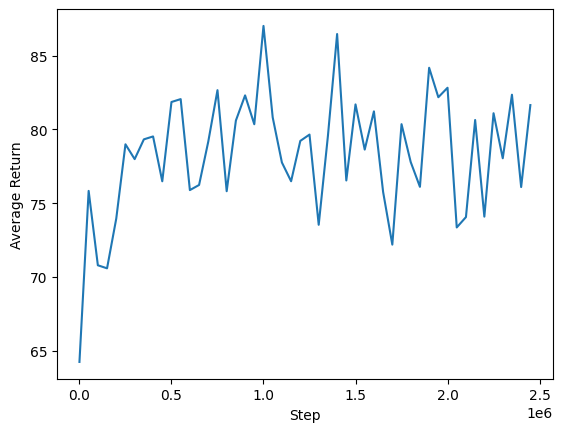

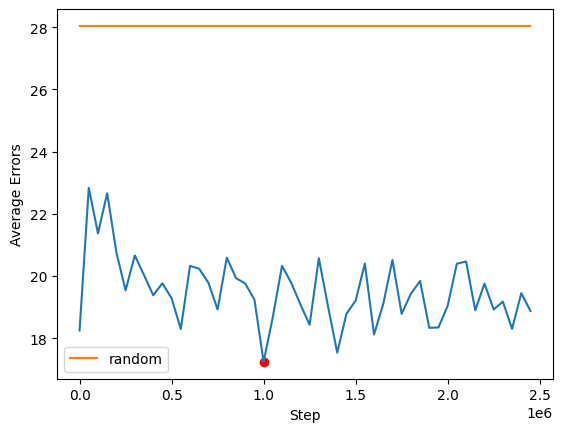

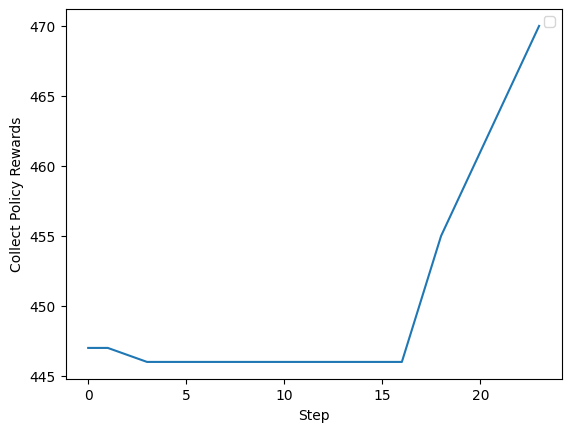

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, n_agents, 500)
print(avg_return, avg_error)

22.477695 17.715553957387616


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, n_agents, 500)
print(avg_return, avg_error)

22.378853 17.984891216551663


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
saved_policy.time_step_spec = agent.policy.time_step_spec
saved_policy.action_spec = agent.policy.action_spec
saved_policy.policy_state_spec = agent.policy.policy_state_spec
saved_policy.info_spec = agent.policy.info_spec
avg_return, avg_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(saved_policy, use_tf_function=True), n_agents, 500)
print(avg_return, avg_error, np.median(errors))

23.659044517040254 16.472092826421008 14.956293937488448
